In [12]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shutil

In [ ]:
# 读取数据
dirty_path = "dirty_cafe_sales.csv"
clean_path = "clean_cafe_sales.csv"

shutil.copyfile(dirty_path, clean_path)

dirty_df = pd.read_csv(dirty_path)
clean_df = pd.read_csv(clean_path)

dirty_df.head()



,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [16]:
clean_df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [31]:
duplicate_ids = clean_df[clean_df['Transaction ID'].duplicated(keep=False)]

if not duplicate_ids.empty:
    print("⚠️ 检测到重复的 Transaction ID：")
    print(duplicate_ids[['Transaction ID', 'Item', 'Total Spent']])
    
    # 删除重复的 Transaction ID，只保留第一次出现的记录
    data = clean_df.drop_duplicates(subset=['Transaction ID'], keep='first')
    print(f"✅ 已删除重复 Transaction ID，共删除 {duplicate_ids['Transaction ID'].nunique()} 条。")
else:
    print("✅ 没有发现重复的 Transaction ID。")

✅ 没有发现重复的 Transaction ID。


In [27]:
def check_data_quality(df):
    """
    检查 DataFrame 各列中 'UNKNOWN'、'ERROR' 和 NaN 的数量。
    """
    keywords = ["UNKNOWN", "ERROR"]
    result = {}

    for col in df.columns:
        # 转换为字符串以便匹配
        col_str = df[col].astype(str).str.upper()
        result[col] = {
            "UNKNOWN": col_str.str.contains("UNKNOWN").sum(),
            "ERROR": col_str.str.contains("ERROR").sum(),
            "NaN": df[col].isna().sum()
        }

    # 打印结果
    print("📊 数据质量检查报告")
    print("-" * 50)
    for col, counts in result.items():
        print(f"{col:20s} | UNKNOWN: {counts['UNKNOWN']:3d} | ERROR: {counts['ERROR']:3d} | NaN: {counts['NaN']:3d}")
    print("-" * 50)

    



In [28]:
check_data_quality(dirty_df)

📊 数据质量检查报告
--------------------------------------------------
Transaction ID       | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Item                 | UNKNOWN: 344 | ERROR: 292 | NaN: 333
Quantity             | UNKNOWN: 171 | ERROR: 170 | NaN: 138
Price Per Unit       | UNKNOWN: 164 | ERROR: 190 | NaN: 179
Total Spent          | UNKNOWN: 165 | ERROR: 164 | NaN: 173
Payment Method       | UNKNOWN: 293 | ERROR: 306 | NaN: 2579
Location             | UNKNOWN: 338 | ERROR: 358 | NaN: 3265
Transaction Date     | UNKNOWN: 159 | ERROR: 142 | NaN: 159
--------------------------------------------------


In [29]:
# 将 Total Spent 中的 ERROR 替换为 NaN
clean_df['Total Spent'] = pd.to_numeric(clean_df['Total Spent'], errors='coerce')
clean_df['Quantity'] = pd.to_numeric(clean_df['Quantity'], errors='coerce')
clean_df['Price Per Unit'] = pd.to_numeric(clean_df['Price Per Unit'], errors='coerce')



# 修复 Total Spent = NaN 的值
clean_df['Total Spent'] = clean_df['Total Spent'].fillna(clean_df['Quantity'] * clean_df['Price Per Unit'])




In [30]:
check_data_quality(clean_df)

📊 数据质量检查报告
--------------------------------------------------
Transaction ID       | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Item                 | UNKNOWN: 344 | ERROR: 292 | NaN: 333
Quantity             | UNKNOWN:   0 | ERROR:   0 | NaN: 479
Price Per Unit       | UNKNOWN:   0 | ERROR:   0 | NaN: 533
Total Spent          | UNKNOWN:   0 | ERROR:   0 | NaN:  40
Payment Method       | UNKNOWN: 293 | ERROR: 306 | NaN: 2579
Location             | UNKNOWN: 338 | ERROR: 358 | NaN: 3265
Transaction Date     | UNKNOWN: 159 | ERROR: 142 | NaN: 159
--------------------------------------------------


In [38]:
import pandas as pd

# 假设 data 是你的 DataFrame
# 确保列是正确的类型
clean_df['Price Per Unit'] = pd.to_numeric(clean_df['Price Per Unit'], errors='coerce')

# 1️⃣ 检查每个商品的唯一单价数量
price_variation = clean_df.groupby('Item')['Price Per Unit'].nunique().reset_index()
price_variation.columns = ['Item', 'Unique_Price_Count']

# 2️⃣ 找出存在多个单价的商品
price_changed_items = price_variation[price_variation['Unique_Price_Count'] > 1]

print("🧾 每个商品的单价变化情况：")
print(price_variation)

print("\n⚠️ 以下商品存在单价不一致：")
print(price_changed_items)

item_prices = clean_df.groupby('Item')['Price Per Unit'].unique().reset_index()
print(item_prices)


🧾 每个商品的单价变化情况：
       Item  Unique_Price_Count
0      Cake                   1
1    Coffee                   1
2    Cookie                   1
3     ERROR                   6
4     Juice                   1
5     Salad                   1
6  Sandwich                   1
7  Smoothie                   1
8       Tea                   1
9   UNKNOWN                   6

⚠️ 以下商品存在单价不一致：
      Item  Unique_Price_Count
3    ERROR                   6
9  UNKNOWN                   6
       Item                       Price Per Unit
0      Cake                           [3.0, nan]
1    Coffee                           [2.0, nan]
2    Cookie                           [1.0, nan]
3     ERROR  [1.5, 3.0, 5.0, nan, 4.0, 2.0, 1.0]
4     Juice                           [3.0, nan]
5     Salad                           [5.0, nan]
6  Sandwich                           [4.0, nan]
7  Smoothie                           [4.0, nan]
8       Tea                           [1.5, nan]
9   UNKNOWN  [3.0, 1.0, 5.0, 4.0,

In [45]:
valid_items = clean_df[~clean_df['Item'].isin(['UNKNOWN', 'ERROR'])]  # 排除异常Item
item_price_map = valid_items.groupby('Item')['Price Per Unit'].first().to_dict()


# 查看字典内容
print("Item 对应价格字典：")
print(item_price_map)



Item 对应价格字典：
{'Cake': 3.0, 'Coffee': 2.0, 'Cookie': 1.0, 'Juice': 3.0, 'Salad': 5.0, 'Sandwich': 4.0, 'Smoothie': 4.0, 'Tea': 1.5}


In [46]:
def fill_price_per_unit(df, item_col='Item', price_col='Price Per Unit', skip_items=None, method='first'):
    """
    通用函数：按 Item 填充 Price Per Unit 的 NaN 值，跳过指定的异常 Item。

    参数：
    df : pd.DataFrame - 数据集
    item_col : str - 商品列名
    price_col : str - 单价列名
    skip_items : list - 不进行填充的异常商品列表，默认 ['UNKNOWN','ERROR']
    method : str - 参考价格获取方法，'first' 或 'mean'

    返回：
    df : pd.DataFrame - 填充后的数据集
    """
    if skip_items is None:
        skip_items = ['UNKNOWN', 'ERROR']

    # 确保价格列为数值型
    df[price_col] = pd.to_numeric(df[price_col], errors='coerce')

    # 生成参考价格，只使用正常商品
    valid_items = df[~df[item_col].isin(skip_items)]
    if method == 'first':
        item_price_map = valid_items.groupby(item_col)[price_col].first().to_dict()
    elif method == 'mean':
        item_price_map = valid_items.groupby(item_col)[price_col].mean().to_dict()
    else:
        raise ValueError("method 参数必须是 'first' 或 'mean'")

    # 定义填充函数
    def fill_price(row):
        if pd.isna(row[price_col]) and row[item_col] not in skip_items:
            return item_price_map.get(row[item_col], np.nan)
        else:
            return row[price_col]

    # 执行填充
    df[price_col] = df.apply(fill_price, axis=1)
    return df

In [60]:
# 假设 data 是你的 DataFrame
fill_price_per_unit(clean_df, item_col='Item', price_col='Price Per Unit', skip_items=['UNKNOWN','ERROR','NaN'], method='first')

# 查看结果
print("填充后 Price Per Unit 中的缺失值数量:", clean_df['Price Per Unit'].isna().sum())
print(clean_df.head(10))


填充后 Price Per Unit 中的缺失值数量: 54
  Transaction ID      Item  Quantity  Price Per Unit  Total Spent  \
0    TXN_1961373    Coffee       2.0             2.0          4.0   
1    TXN_4977031      Cake       4.0             3.0         12.0   
2    TXN_4271903    Cookie       4.0             1.0          4.0   
3    TXN_7034554     Salad       2.0             5.0         10.0   
4    TXN_3160411    Coffee       2.0             2.0          4.0   
5    TXN_2602893  Smoothie       5.0             4.0         20.0   
6    TXN_4433211     Juice       3.0             3.0          9.0   
7    TXN_6699534  Sandwich       4.0             4.0         16.0   
8    TXN_4717867     Juice       5.0             3.0         15.0   
9    TXN_2064365  Sandwich       5.0             4.0         20.0   

   Payment Method  Location Transaction Date Item_filled  
0     Credit Card  Takeaway       2023-09-08      Coffee  
1            Cash  In-store       2023-05-16        Cake  
2     Credit Card  In-store     

In [61]:
item_sales = clean_df.groupby('Item')['Quantity'].sum().to_dict()
print(item_sales)

# 2️⃣ 建立价格到候选 Item 列表映射
from collections import defaultdict
price_to_items = defaultdict(list)
for k,v in item_price_map.items():
    price_to_items[v].append(k)


# 3️⃣ 对于每个价格对应的候选商品，按销量高排序
for price, items in price_to_items.items():
    items.sort(key=lambda x: item_sales.get(x,0), reverse=True)
print(price_to_items)  # 可以查看映射关系

# 4️⃣ 填充异常 Item
def fill_item(row):
    if row['Item'] in ['ERROR','UNKNOWN','NaN', None, np.nan]:
        candidates = price_to_items.get(row['Price Per Unit'], [])
        if candidates:
            return candidates[0]  # 选择销量最高的候选商品
    return row['Item']

clean_df['Item'] = clean_df.apply(fill_item, axis=1)

# 5️⃣ 查看结果

print("\n填充后数据：")
print(clean_df[['Item','Price Per Unit','Quantity']])

{'Cake': 3468.0, 'Coffee': 3878.0, 'Cookie': 3585.0, 'ERROR': 39.0, 'Juice': 4209.0, 'Salad': 3815.0, 'Sandwich': 4095.0, 'Smoothie': 3336.0, 'Tea': 3622.0, 'UNKNOWN': 54.0}
defaultdict(<class 'list'>, {3.0: ['Juice', 'Cake'], 2.0: ['Coffee'], 1.0: ['Cookie'], 5.0: ['Salad'], 4.0: ['Sandwich', 'Smoothie'], 1.5: ['Tea']})

填充后数据：
          Item  Price Per Unit  Quantity
0       Coffee             2.0       2.0
1         Cake             3.0       4.0
2       Cookie             1.0       4.0
3        Salad             5.0       2.0
4       Coffee             2.0       2.0
...        ...             ...       ...
9995    Coffee             2.0       2.0
9996       NaN             NaN       3.0
9997    Coffee             2.0       4.0
9998    Cookie             1.0       3.0
9999  Sandwich             4.0       3.0

[10000 rows x 3 columns]


In [62]:
clean_df['Total Spent'] = clean_df['Total Spent'].fillna(clean_df['Quantity'] * clean_df['Price Per Unit'])

In [63]:
check_data_quality(clean_df)

📊 数据质量检查报告
--------------------------------------------------
Transaction ID       | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Item                 | UNKNOWN:  18 | ERROR:  13 | NaN:  23
Quantity             | UNKNOWN:   0 | ERROR:   0 | NaN:  23
Price Per Unit       | UNKNOWN:   0 | ERROR:   0 | NaN:  54
Total Spent          | UNKNOWN:   0 | ERROR:   0 | NaN:  23
Payment Method       | UNKNOWN: 293 | ERROR: 306 | NaN: 2579
Location             | UNKNOWN: 338 | ERROR: 358 | NaN: 3265
Transaction Date     | UNKNOWN: 159 | ERROR: 142 | NaN: 159
Item_filled          | UNKNOWN:  18 | ERROR:  13 | NaN:  23
--------------------------------------------------


In [64]:
clean_df['Quantity'] = clean_df['Quantity'].fillna(clean_df['Total Spent'] / clean_df['Price Per Unit'])

In [65]:
check_data_quality(clean_df)


📊 数据质量检查报告
--------------------------------------------------
Transaction ID       | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Item                 | UNKNOWN:  18 | ERROR:  13 | NaN:  23
Quantity             | UNKNOWN:   0 | ERROR:   0 | NaN:  23
Price Per Unit       | UNKNOWN:   0 | ERROR:   0 | NaN:  54
Total Spent          | UNKNOWN:   0 | ERROR:   0 | NaN:  23
Payment Method       | UNKNOWN: 293 | ERROR: 306 | NaN: 2579
Location             | UNKNOWN: 338 | ERROR: 358 | NaN: 3265
Transaction Date     | UNKNOWN: 159 | ERROR: 142 | NaN: 159
Item_filled          | UNKNOWN:  18 | ERROR:  13 | NaN:  23
--------------------------------------------------


In [68]:
# 1️⃣ 修正 Total Spent 与 Quantity * Price Per Unit 不一致的记录
mask_total_mismatch = ~clean_df['Quantity'].isna() & ~clean_df['Price Per Unit'].isna() & \
                      ~clean_df['Total Spent'].isna() & \
                      (clean_df['Quantity'] * clean_df['Price Per Unit'] != clean_df['Total Spent'])
print(f"修正前 Total Spent 与 Quantity * Price 不一致的记录数: {mask_total_mismatch.sum()}")

# 将 Total Spent 修正为 Quantity * Price
clean_df.loc[mask_total_mismatch, 'Total Spent'] = clean_df.loc[mask_total_mismatch, 'Quantity'] * clean_df.loc[mask_total_mismatch, 'Price Per Unit']

# 2️⃣ 填充缺失的 Quantity
mask_qty_missing = clean_df['Quantity'].isna() & clean_df['Price Per Unit'].notna() & clean_df['Total Spent'].notna()
clean_df.loc[mask_qty_missing, 'Quantity'] = clean_df.loc[mask_qty_missing, 'Total Spent'] / clean_df.loc[mask_qty_missing, 'Price Per Unit']

# 3️⃣ 再次检查是否还有不一致
mask_still_mismatch = ~clean_df['Quantity'].isna() & ~clean_df['Price Per Unit'].isna() & ~clean_df['Total Spent'].isna() & \
                      (clean_df['Quantity'] * clean_df['Price Per Unit'] != clean_df['Total Spent'])

print(f"修正后仍有不一致的记录数: {mask_still_mismatch.sum()}")

# 4️⃣ 可选：四舍五入 Quantity 为整数（如果是实际数量）
clean_df['Quantity'] = clean_df['Quantity'].round()

修正前 Total Spent 与 Quantity * Price 不一致的记录数: 0
修正后仍有不一致的记录数: 0


In [69]:
mask_total_mismatch = ~clean_df['Quantity'].isna() & ~clean_df['Price Per Unit'].isna() & \
                      ~clean_df['Total Spent'].isna() & \
                      (clean_df['Quantity'] != clean_df['Total Spent']/ clean_df['Price Per Unit'] )
print(f"修正前 Total Spent 与 Quantity * Price 不一致的记录数: {mask_total_mismatch.sum()}")

# 将 Total Spent 修正为 Quantity * Price
clean_df.loc[mask_total_mismatch, 'Quantity'] = clean_df.loc[mask_total_mismatch, 'Total Spent'] / clean_df.loc[mask_total_mismatch, 'Price Per Unit']

# 2️⃣ 填充缺失的 Quantity
mask_qty_missing = clean_df['Quantity'].isna() & clean_df['Price Per Unit'].notna() & clean_df['Total Spent'].notna()
clean_df.loc[mask_qty_missing, 'Quantity'] = clean_df.loc[mask_qty_missing, 'Total Spent'] / clean_df.loc[mask_qty_missing, 'Price Per Unit']

# 3️⃣ 再次检查是否还有不一致
mask_still_mismatch = ~clean_df['Quantity'].isna() & ~clean_df['Price Per Unit'].isna() & ~clean_df['Total Spent'].isna() & \
                      (clean_df['Quantity'] * clean_df['Price Per Unit'] != clean_df['Total Spent'])

print(f"修正后仍有不一致的记录数: {mask_still_mismatch.sum()}")

# 4️⃣ 可选：四舍五入 Quantity 为整数（如果是实际数量）
clean_df['Quantity'] = clean_df['Quantity'].round()

修正前 Total Spent 与 Quantity * Price 不一致的记录数: 0
修正后仍有不一致的记录数: 0


In [73]:
clean_df = clean_df[~clean_df['Payment Method'].isin(['UNKNOWN','ERROR','NaN', None, np.nan])]
clean_df = clean_df[~clean_df['Location'].isin(['UNKNOWN','ERROR','NaN', None, np.nan])]

In [74]:
check_data_quality(clean_df)

📊 数据质量检查报告
--------------------------------------------------
Transaction ID       | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Item                 | UNKNOWN:   5 | ERROR:   3 | NaN:   9
Quantity             | UNKNOWN:   0 | ERROR:   0 | NaN:  11
Price Per Unit       | UNKNOWN:   0 | ERROR:   0 | NaN:  17
Total Spent          | UNKNOWN:   0 | ERROR:   0 | NaN:  10
Payment Method       | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Location             | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Transaction Date     | UNKNOWN:  58 | ERROR:  64 | NaN:  58
Item_filled          | UNKNOWN:   5 | ERROR:   3 | NaN:   9
--------------------------------------------------


In [75]:
len(clean_df)

4155

In [80]:
mask_total_mismatch = ~clean_df['Quantity'].isna() & ~clean_df['Price Per Unit'].isna() & \
                      ~clean_df['Total Spent'].isna() & \
                      (clean_df['Price Per Unit'] != clean_df['Total Spent']/ clean_df['Quantity'] )
print(f"修正前 Total Spent 与 Quantity * Price 不一致的记录数: {mask_total_mismatch.sum()}")

# 将 Total Spent 修正为 Quantity * Price
clean_df.loc[mask_total_mismatch, 'Price Per Unit'] = clean_df.loc[mask_total_mismatch, 'Total Spent'] / clean_df.loc[mask_total_mismatch, 'Quantity']

# 2️⃣ 填充缺失的 Quantity
mask_qty_missing = clean_df['Quantity'].isna() & clean_df['Price Per Unit'].notna() & clean_df['Total Spent'].notna()
clean_df.loc[mask_qty_missing, 'Quantity'] = clean_df.loc[mask_qty_missing, 'Total Spent'] / clean_df.loc[mask_qty_missing, 'Price Per Unit']

# 3️⃣ 再次检查是否还有不一致
mask_still_mismatch = ~clean_df['Quantity'].isna() & ~clean_df['Price Per Unit'].isna() & ~clean_df['Total Spent'].isna() & \
                      (clean_df['Quantity'] * clean_df['Price Per Unit'] != clean_df['Total Spent'])

print(f"修正后仍有不一致的记录数: {mask_still_mismatch.sum()}")

# 4️⃣ 可选：四舍五入 Quantity 为整数（如果是实际数量）
clean_df['Quantity'] = clean_df['Quantity'].round()

修正前 Total Spent 与 Quantity * Price 不一致的记录数: 0
修正后仍有不一致的记录数: 0


In [84]:
before_fix = clean_df["Item"].value_counts().get("error", 0) + clean_df["Item"].value_counts().get("unknown", 0)
print(f"🛠️ 修正前 error/unknown 数量：{before_fix}")

# 6️⃣ 修复逻辑
def infer_item(row):
    if row["Item"] in ["error", "unknown"]:
        price = round(row["Price Per Unit"], 1)
        # 找最接近的价格（允许浮点误差）
        matched_price = min(item_price_map.values(), key=lambda x: abs(x - price))
        candidates = price_to_items.get(matched_price, [])
        if candidates:
            return candidates[0]  # 销量最高的那个
    return row["Item"]

clean_df["Fixed Item"] = clean_df.apply(infer_item, axis=1)

# 7️⃣ 修正后统计
after_fix = (clean_df["Fixed Item"].isin(["error", "unknown"])).sum()
print(f"✅ 修正后剩余未识别 Item 数量：{after_fix}")

# 8️⃣ 对比预览（可选）
print(clean_df.loc[clean_df["Item"].isin(["error", "unknown"]), ["Item", "Price Per Unit", "Fixed Item"]].head())

🛠️ 修正前 error/unknown 数量：0
✅ 修正后剩余未识别 Item 数量：0
Empty DataFrame
Columns: [Item, Price Per Unit, Fixed Item]
Index: []


In [85]:
import pandas as pd
from datetime import timedelta


df = clean_df.copy()
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"], errors='coerce')

for i in range(len(df)):
    if pd.isna(df.iloc[i]["Transaction Date"]):
        prev_date = next_date = None

        # 向上找
        j = i - 1
        while j >= 0:
            if pd.notna(df.iloc[j]["Transaction Date"]):
                prev_date = df.iloc[j]["Transaction Date"]
                break
            j -= 1

        # 向下找
        k = i + 1
        while k < len(df):
            if pd.notna(df.iloc[k]["Transaction Date"]):
                next_date = df.iloc[k]["Transaction Date"]
                break
            k += 1

        # 平均日期填充
        if prev_date and next_date:
            df.iloc[i, df.columns.get_loc("Transaction Date")] = prev_date + (next_date - prev_date) / 2
        elif prev_date:
            df.iloc[i, df.columns.get_loc("Transaction Date")] = prev_date
        elif next_date:
            df.iloc[i, df.columns.get_loc("Transaction Date")] = next_date



In [86]:
check_data_quality(df)

📊 数据质量检查报告
--------------------------------------------------
Transaction ID       | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Item                 | UNKNOWN:   5 | ERROR:   3 | NaN:   9
Quantity             | UNKNOWN:   0 | ERROR:   0 | NaN:  11
Price Per Unit       | UNKNOWN:   0 | ERROR:   0 | NaN:  17
Total Spent          | UNKNOWN:   0 | ERROR:   0 | NaN:  10
Payment Method       | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Location             | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Transaction Date     | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Item_filled          | UNKNOWN:   5 | ERROR:   3 | NaN:   9
Fixed Item           | UNKNOWN:   5 | ERROR:   3 | NaN:   9
--------------------------------------------------


In [87]:
import pandas as pd
clean_df = df.copy()
# 🧩 假设 clean_df 已经加载并含有上述列

# 1️⃣ 删除包含 'error' 或 'unknown' 的行（任何列中出现都删除）
clean_df = clean_df[
    ~clean_df.isin(['error', 'unknown']).any(axis=1)
]

# 2️⃣ 删除包含 NaN 的行
clean_df = clean_df.dropna()

# 3️⃣ 删除最后两列（Item_filled 和 Fixed Item）
clean_df = clean_df.drop(columns=['Item_filled', 'Fixed Item'], errors='ignore')

# 4️⃣ 输出清洗后报告
print("✅ 清洗完成！")
print(f"剩余行数: {len(clean_df)}")
print(f"剩余列: {list(clean_df.columns)}")


✅ 清洗完成！
剩余行数: 4128
剩余列: ['Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent', 'Payment Method', 'Location', 'Transaction Date']


In [88]:
check_data_quality(clean_df)

📊 数据质量检查报告
--------------------------------------------------
Transaction ID       | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Item                 | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Quantity             | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Price Per Unit       | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Total Spent          | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Payment Method       | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Location             | UNKNOWN:   0 | ERROR:   0 | NaN:   0
Transaction Date     | UNKNOWN:   0 | ERROR:   0 | NaN:   0
--------------------------------------------------


In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# 按商品汇总
item_summary = (
    clean_df.groupby("Item")
    .agg(
        Total_Sales=("Quantity", "sum"),
        Total_Revenue=("Total Spent", "sum"),
        Avg_Unit_Price=("Price Per Unit", "mean")
    )
    .sort_values(by="Total_Revenue", ascending=False)
)

print("📊 商品销售汇总：")
print(item_summary)


📊 商品销售汇总：
          Total_Sales  Total_Revenue  Avg_Unit_Price
Item                                                
Salad          1660.0         8300.0             5.0
Sandwich       1787.0         7148.0             4.0
Juice          1770.0         5310.0             3.0
Smoothie       1254.0         5016.0             4.0
Cake           1414.0         4242.0             3.0
Coffee         1516.0         3032.0             2.0
Tea            1508.0         2262.0             1.5
Cookie         1594.0         1594.0             1.0


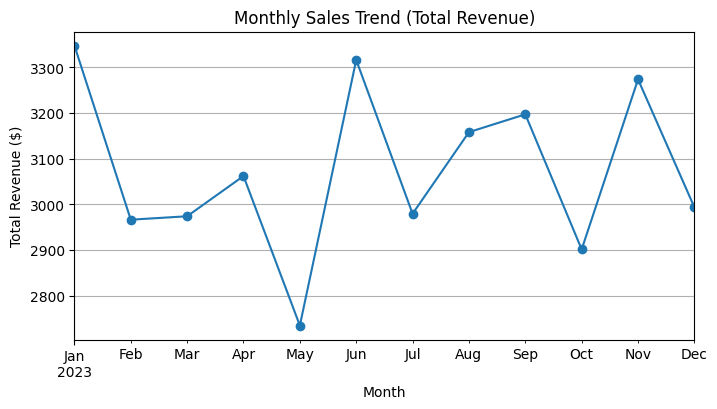

In [90]:
# 转换日期
clean_df["Transaction Date"] = pd.to_datetime(clean_df["Transaction Date"])
clean_df["Month"] = clean_df["Transaction Date"].dt.to_period("M")

# 月度汇总
monthly_revenue = clean_df.groupby("Month")["Total Spent"].sum()

# 绘图
plt.figure(figsize=(8,4))
monthly_revenue.plot(marker="o")
plt.title("Monthly Sales Trend (Total Revenue)")
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.grid(True)
plt.show()


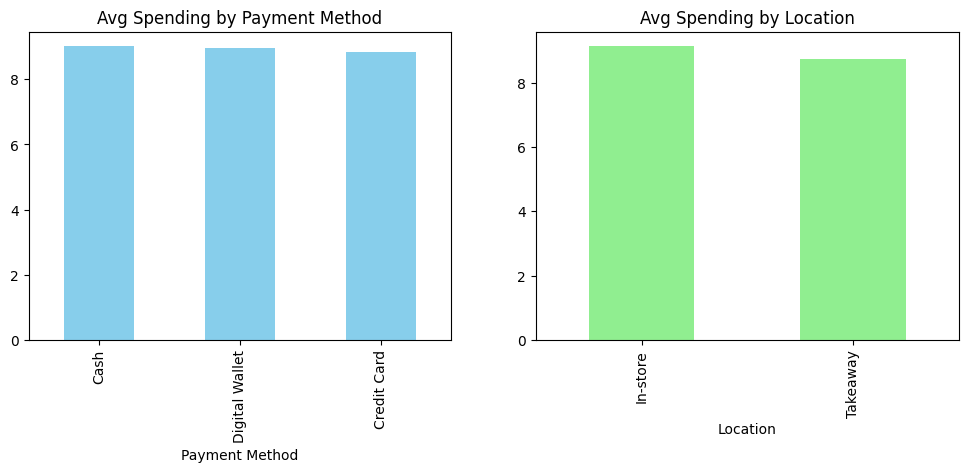

In [91]:
payment_summary = clean_df.groupby("Payment Method")["Total Spent"].mean().sort_values(ascending=False)
location_summary = clean_df.groupby("Location")["Total Spent"].mean().sort_values(ascending=False)

# 绘图
fig, axes = plt.subplots(1, 2, figsize=(12,4))
payment_summary.plot(kind="bar", ax=axes[0], color="skyblue", title="Avg Spending by Payment Method")
location_summary.plot(kind="bar", ax=axes[1], color="lightgreen", title="Avg Spending by Location")
plt.show()


In [92]:
best_item = item_summary["Total_Sales"].idxmax()
monthly_change = monthly_revenue.pct_change().fillna(0)
worst_month = monthly_change.idxmin()

print(f"🏆 最畅销商品: {best_item}")
print(f"📉 销售下滑最严重的月份: {worst_month}")


🏆 最畅销商品: Sandwich
📉 销售下滑最严重的月份: 2023-02


In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# 特征工程
X = clean_df[["Quantity", "Price Per Unit", "Payment Method", "Location"]]
X = pd.get_dummies(X, drop_first=True)
y = clean_df["Total Spent"]

# 划分数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 建模
model = LinearRegression()
model.fit(X_train, y_train)

# 预测与评估
y_pred = model.predict(X_test)
print(f"R²: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")


R²: 0.906
MAE: 1.31


In [94]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("📈 模型系数分析：")
print(coef_df)


📈 模型系数分析：
                         Feature  Coefficient
1                 Price Per Unit     3.012465
0                       Quantity     2.961090
3  Payment Method_Digital Wallet     0.167842
2     Payment Method_Credit Card     0.103747
4              Location_Takeaway    -0.039643


In [95]:
import pandas as pd

# 确保日期列正确
clean_df["Transaction Date"] = pd.to_datetime(clean_df["Transaction Date"])
clean_df["Month"] = clean_df["Transaction Date"].dt.to_period("M")

# 构造月度汇总
monthly_df = (
    clean_df.groupby("Month")
    .agg(
        total_revenue=("Total Spent", "sum"),
        avg_price=("Price Per Unit", "mean"),
        avg_quantity=("Quantity", "mean"),
        avg_spent=("Total Spent", "mean"),
        transaction_count=("Transaction ID", "count")
    )
    .reset_index()
)

# 转换成时间戳
monthly_df["Month"] = monthly_df["Month"].dt.to_timestamp()
print(monthly_df.head())


       Month  total_revenue  avg_price  avg_quantity  avg_spent  \
0 2023-01-01         3347.5   2.994565      3.035326   9.096467   
1 2023-02-01         2966.5   2.931250      3.200000   9.270312   
2 2023-03-01         2974.0   2.908696      2.907246   8.620290   
3 2023-04-01         3062.0   3.037994      3.072948   9.306991   
4 2023-05-01         2735.0   2.940895      3.000000   8.738019   

   transaction_count  
0                368  
1                320  
2                345  
3                329  
4                313  


In [96]:
monthly_df["lag_1"] = monthly_df["total_revenue"].shift(1)
monthly_df["growth_rate"] = monthly_df["total_revenue"].pct_change().fillna(0)
monthly_df = monthly_df.dropna()


In [97]:
from sklearn.linear_model import LinearRegression

# 自变量与目标变量
X = monthly_df[["avg_price", "avg_quantity", "avg_spent", "transaction_count", "lag_1", "growth_rate"]]
y = monthly_df["total_revenue"]

# 训练模型
model = LinearRegression()
model.fit(X, y)

print("✅ 模型训练完成。")


✅ 模型训练完成。


In [98]:
# 获取最近一个月数据
latest = monthly_df.iloc[-1]

# 构造下一月特征行
next_month_features = pd.DataFrame({
    "avg_price": [latest["avg_price"]],
    "avg_quantity": [latest["avg_quantity"]],
    "avg_spent": [latest["avg_spent"]],
    "transaction_count": [latest["transaction_count"]],
    "lag_1": [latest["total_revenue"]],
    "growth_rate": [latest["growth_rate"]]
})

# 预测
predicted_revenue = model.predict(next_month_features)[0]
print(f"📈 预测 2025-01 销售总额: ${predicted_revenue:,.2f}")


📈 预测 2025-01 销售总额: $2,946.39


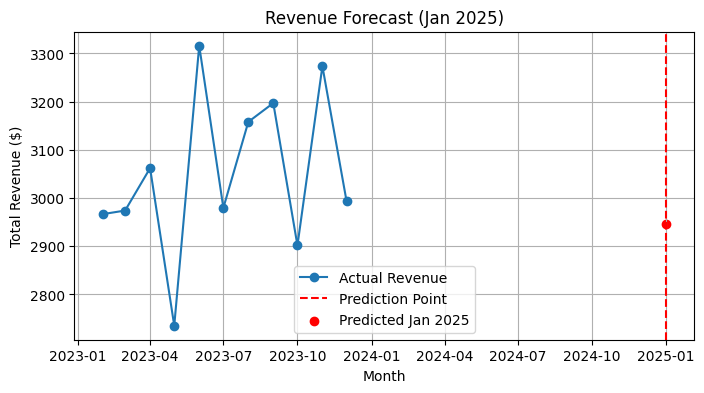

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(monthly_df["Month"], monthly_df["total_revenue"], marker="o", label="Actual Revenue")
plt.axvline(pd.Timestamp("2025-01-01"), color="red", linestyle="--", label="Prediction Point")
plt.scatter(pd.Timestamp("2025-01-01"), predicted_revenue, color="red", label="Predicted Jan 2025")
plt.title("Revenue Forecast (Jan 2025)")
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.legend()
plt.grid(True)
plt.show()


In [113]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def predict_monthly_sales_series(clean_df, target_month="2025-01"):
    """
    根据历史交易数据，预测从历史最后一个月到目标月份之间每个月的销售额。
    
    参数:
        clean_df : DataFrame
            含 Transaction Date, Total Spent, Quantity, Price Per Unit 等列
        target_month : str
            目标月份 (格式: YYYY-MM)
            
    返回:
        predictions_df : DataFrame
            预测月份及对应预测销售额
    """
    
    # Step 1: 日期预处理
    df = clean_df.copy()
    df["Transaction Date"] = pd.to_datetime(df["Transaction Date"])
    df["Month"] = df["Transaction Date"].dt.to_period("M")
    
    # Step 2: 月度汇总
    monthly_df = (
        df.groupby("Month")
        .agg(
            total_revenue=("Total Spent", "sum"),
            avg_price=("Price Per Unit", "mean"),
            avg_quantity=("Quantity", "mean"),
            avg_spent=("Total Spent", "mean"),
            transaction_count=("Transaction ID", "count")
        )
        .reset_index()
    )
    monthly_df["Month"] = monthly_df["Month"].dt.to_timestamp()
    
    # Step 3: 添加滞后特征
    monthly_df["lag_1"] = monthly_df["total_revenue"].shift(1)
    monthly_df["growth_rate"] = monthly_df["total_revenue"].pct_change().fillna(0)
    monthly_df = monthly_df.dropna()
    
    # Step 4: 训练模型
    feature_cols = ["avg_price", "avg_quantity", "avg_spent", "transaction_count", "lag_1", "growth_rate"]
    X = monthly_df[feature_cols]
    y = monthly_df["total_revenue"]
    model = LinearRegression()
    model.fit(X, y)
    
    # Step 5: 构建预测月份序列
    last_month = monthly_df["Month"].max()
    target_month_ts = pd.to_datetime(target_month + "-01")
    month_list = pd.date_range(last_month + pd.offsets.MonthBegin(1), target_month_ts, freq='MS')
    
    # Step 6: 滚动预测
    predictions = []
    prev_features = monthly_df.iloc[-1][feature_cols].copy()
    
    for month in month_list:
        # 构造当前月的特征
        current_features = prev_features.copy()
        # 使用上个月预测值作为 lag_1
        current_features["lag_1"] = prev_features["lag_1"] if "lag_1" not in prev_features else prev_features["lag_1"]
        # growth_rate使用0作为简单近似（可优化）
        avg_growth = monthly_df["growth_rate"].tail(3).mean()
        current_features["growth_rate"] = avg_growth
        
        # 预测
        predicted = model.predict([current_features.values])[0]
        predictions.append({"Month": month, "Predicted_Revenue": predicted})
        
        # 更新 prev_features
        prev_features["lag_1"] = predicted
    
    predictions_df = pd.DataFrame(predictions)
    
    # Step 7: 可视化
    plt.figure(figsize=(10,4))
    plt.plot(monthly_df["Month"], monthly_df["total_revenue"], marker="o", label="Actual Revenue")
    plt.plot(predictions_df["Month"], predictions_df["Predicted_Revenue"], marker="x", color="red", label="Predicted Revenue")
    plt.title(f"Revenue Forecast from {last_month.strftime('%Y-%m')} to {target_month}")
    plt.xlabel("Month")
    plt.ylabel("Total Revenue ($)")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print("📈 预测结果：")
    print(predictions_df)
    
    return predictions_df


d:\python\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\python\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\python\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\python\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\python\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\python\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn

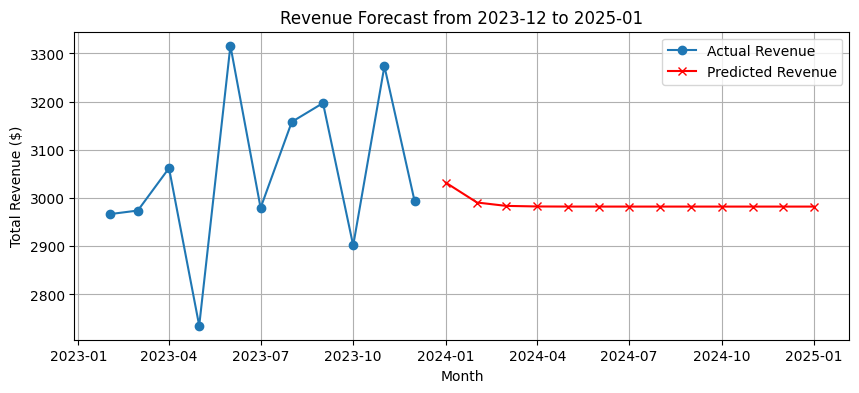

📈 预测结果：
        Month  Predicted_Revenue
0  2024-01-01        3031.883359
1  2024-02-01        2990.680030
2  2024-03-01        2983.653550
3  2024-04-01        2982.455312
4  2024-05-01        2982.250974
5  2024-06-01        2982.216128
6  2024-07-01        2982.210186
7  2024-08-01        2982.209172
8  2024-09-01        2982.208999
9  2024-10-01        2982.208970
10 2024-11-01        2982.208965
11 2024-12-01        2982.208964
12 2025-01-01        2982.208964


,Month,Predicted_Revenue
0,2024-01-01,3031.883359
1,2024-02-01,2990.680030
2,2024-03-01,2983.653550
3,2024-04-01,2982.455312
4,2024-05-01,2982.250974
5,2024-06-01,2982.216128
6,2024-07-01,2982.210186
7,2024-08-01,2982.209172
8,2024-09-01,2982.208999
9,2024-10-01,2982.208970


In [114]:
predict_monthly_sales_series(clean_df, target_month="2025-01")




In [115]:
import pandas as pd

# 确保日期列正确
df = clean_df.copy()
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"])
df["Month"] = df["Transaction Date"].dt.to_period("M")

# 按月 + 支付方式统计
monthly_payment = (
    df.groupby(["Month", "Payment Method"])
    .agg(
        num_customers=("Transaction ID", "count"),   # 交易次数可以近似人数
        total_amount=("Total Spent", "sum")
    )
    .reset_index()
)

print(monthly_payment.head())


     Month  Payment Method  num_customers  total_amount
0  2023-01            Cash            117        1109.5
1  2023-01     Credit Card            133        1197.5
2  2023-01  Digital Wallet            118        1040.5
3  2023-02            Cash            108         974.0
4  2023-02     Credit Card            108        1002.5


In [118]:
# 每月总人数与总金额
monthly_totals = monthly_payment.groupby("Month").agg(
    total_customers=("num_customers", "sum"),
    total_amount=("total_amount", "sum")
).reset_index()

# merge 后，monthly_totals 的 total_amount 会变成 total_amount_y
monthly_payment = monthly_payment.merge(monthly_totals, on="Month", suffixes=("", "_month_total"))

# 人数占比
monthly_payment["customer_share"] = monthly_payment["num_customers"] / monthly_payment["total_customers"]

# 金额占比
monthly_payment["amount_share"] = monthly_payment["total_amount"] / monthly_payment["total_amount_month_total"]

# 可选：格式化百分比
monthly_payment["customer_share"] = (monthly_payment["customer_share"] * 100).round(2)
monthly_payment["amount_share"] = (monthly_payment["amount_share"] * 100).round(2)

print(monthly_payment.head())



     Month  Payment Method  num_customers  total_amount_x  total_customers  \
0  2023-01            Cash            117          1109.5              368   
1  2023-01     Credit Card            133          1197.5              368   
2  2023-01  Digital Wallet            118          1040.5              368   
3  2023-02            Cash            108           974.0              320   
4  2023-02     Credit Card            108          1002.5              320   

   total_amount_y  customer_share  total_customers_month_total  total_amount  \
0          3347.5           31.79                          368        3347.5   
1          3347.5           36.14                          368        3347.5   
2          3347.5           32.07                          368        3347.5   
3          2966.5           33.75                          320        2966.5   
4          2966.5           33.75                          320        2966.5   

   total_customers_month_total  total_amount_month

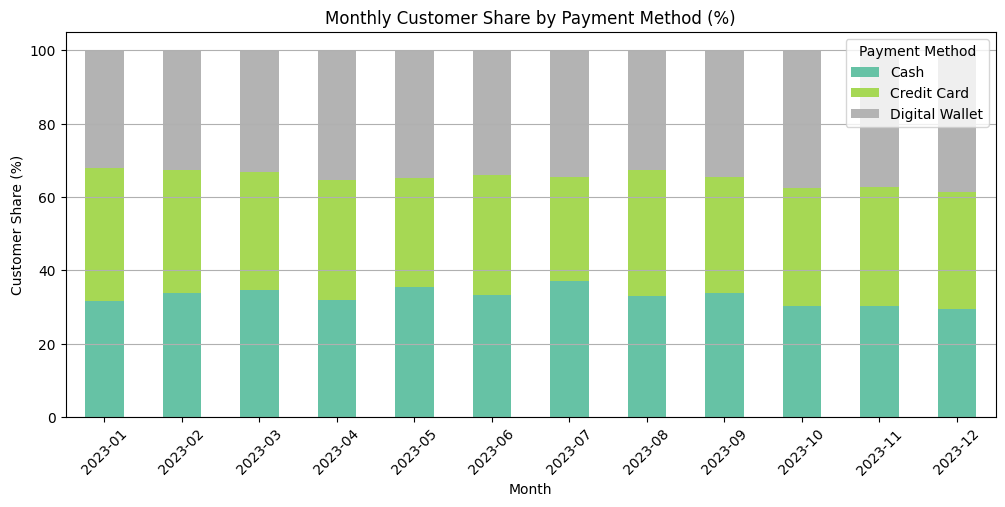

In [119]:
import matplotlib.pyplot as plt

# 按月+支付方式透视表
customer_pivot = monthly_payment.pivot(index="Month", columns="Payment Method", values="customer_share").fillna(0)

# 堆叠柱状图
customer_pivot.plot(kind="bar", stacked=True, figsize=(12,5), colormap="Set2")
plt.title("Monthly Customer Share by Payment Method (%)")
plt.ylabel("Customer Share (%)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Payment Method")
plt.grid(axis="y")
plt.show()


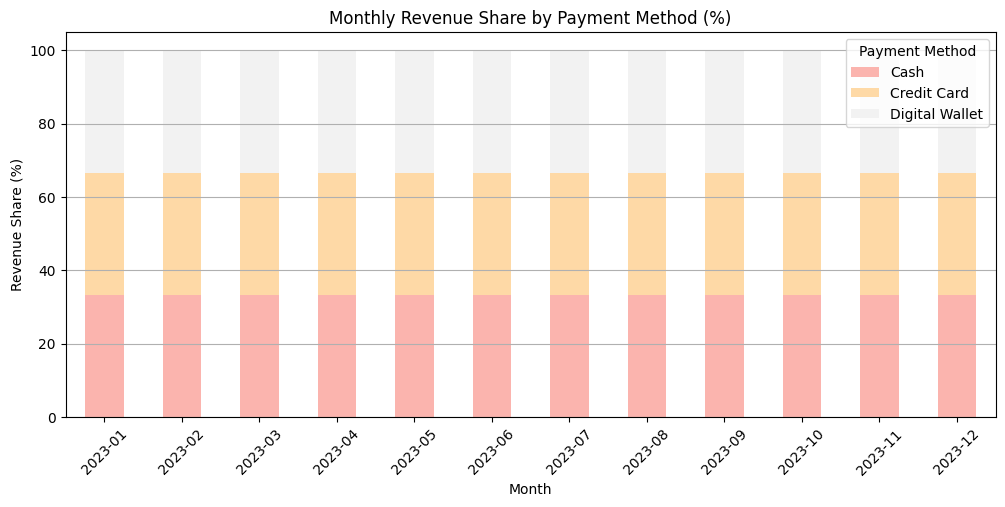

In [120]:
amount_pivot = monthly_payment.pivot(index="Month", columns="Payment Method", values="amount_share").fillna(0)

# 堆叠柱状图
amount_pivot.plot(kind="bar", stacked=True, figsize=(12,5), colormap="Pastel1")
plt.title("Monthly Revenue Share by Payment Method (%)")
plt.ylabel("Revenue Share (%)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Payment Method")
plt.grid(axis="y")
plt.show()


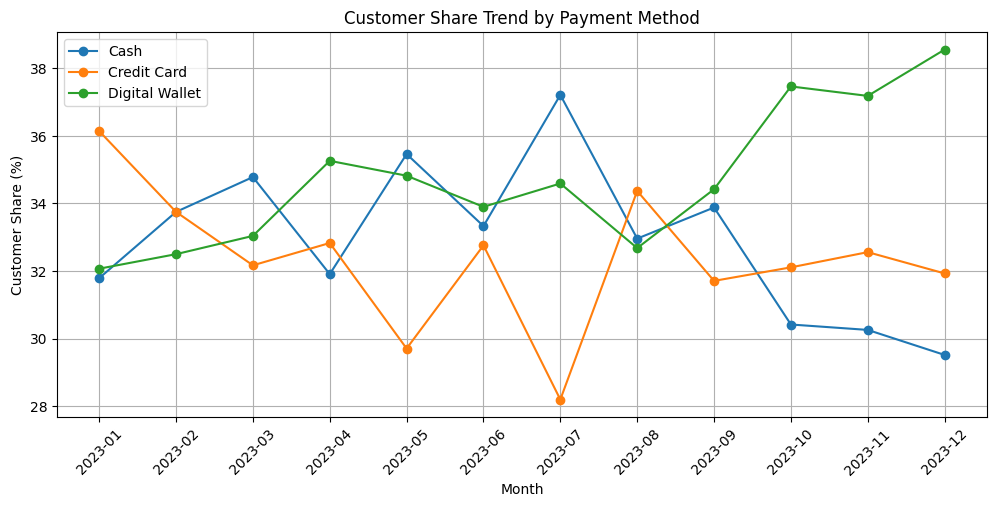

In [121]:
plt.figure(figsize=(12,5))
for method in monthly_payment["Payment Method"].unique():
    subset = monthly_payment[monthly_payment["Payment Method"]==method]
    plt.plot(subset["Month"].astype(str), subset["customer_share"], marker="o", label=method)
plt.title("Customer Share Trend by Payment Method")
plt.ylabel("Customer Share (%)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


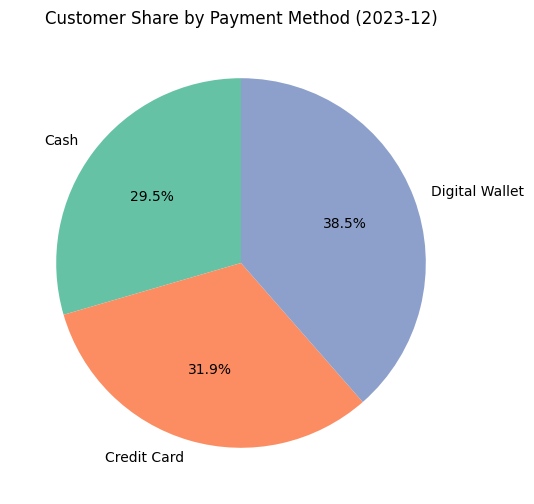

In [122]:
import matplotlib.pyplot as plt

# 选择某个月份
month_to_plot = monthly_payment["Month"].max()  # 可改成其他月份
subset = monthly_payment[monthly_payment["Month"] == month_to_plot]

plt.figure(figsize=(6,6))
plt.pie(subset["customer_share"], labels=subset["Payment Method"], autopct="%1.1f%%", startangle=90, colors=plt.cm.Set2.colors)
plt.title(f"Customer Share by Payment Method ({month_to_plot.strftime('%Y-%m')})")
plt.show()


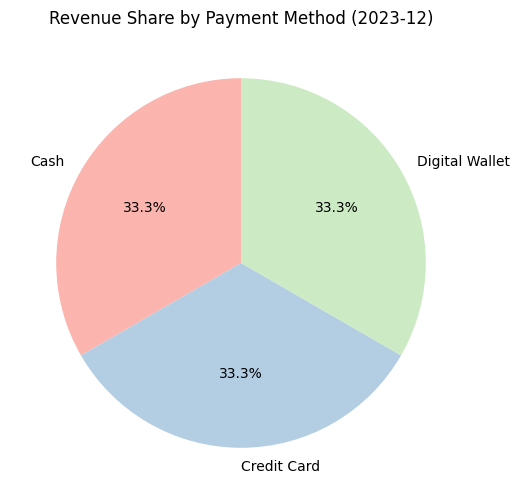

In [123]:
subset = monthly_payment[monthly_payment["Month"] == month_to_plot]

plt.figure(figsize=(6,6))
plt.pie(subset["amount_share"], labels=subset["Payment Method"], autopct="%1.1f%%", startangle=90, colors=plt.cm.Pastel1.colors)
plt.title(f"Revenue Share by Payment Method ({month_to_plot.strftime('%Y-%m')})")
plt.show()


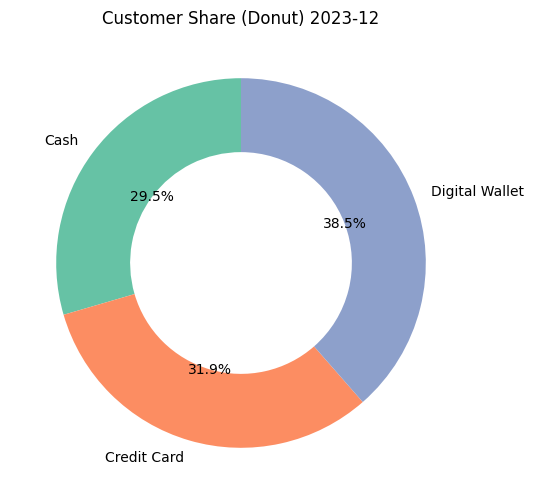

In [124]:
subset = monthly_payment[monthly_payment["Month"] == month_to_plot]
plt.figure(figsize=(6,6))
plt.pie(subset["customer_share"], labels=subset["Payment Method"], autopct="%1.1f%%", startangle=90, colors=plt.cm.Set2.colors, wedgeprops=dict(width=0.4))
plt.title(f"Customer Share (Donut) {month_to_plot.strftime('%Y-%m')}")
plt.show()


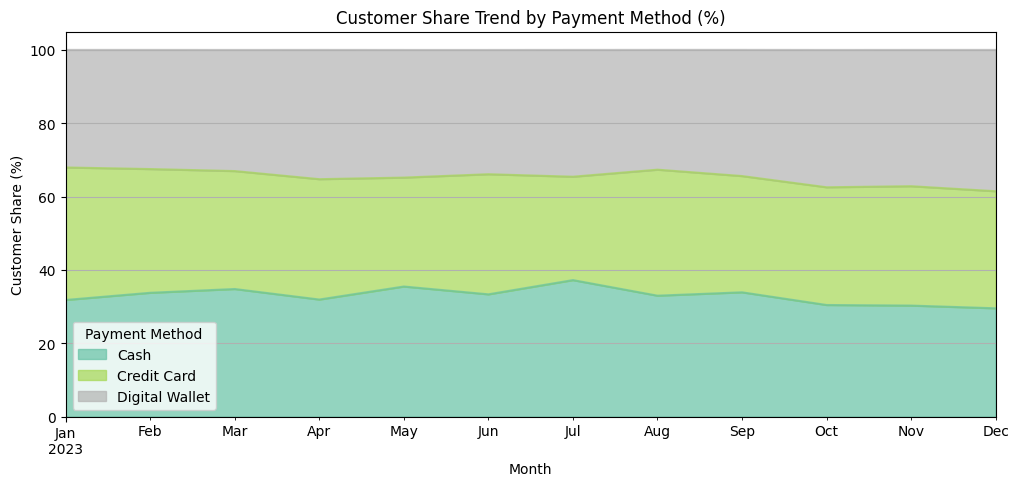

In [125]:
customer_pivot = monthly_payment.pivot(index="Month", columns="Payment Method", values="customer_share").fillna(0)
customer_pivot.plot.area(figsize=(12,5), cmap="Set2", alpha=0.7)
plt.title("Customer Share Trend by Payment Method (%)")
plt.ylabel("Customer Share (%)")
plt.xlabel("Month")
plt.grid(True)
plt.show()


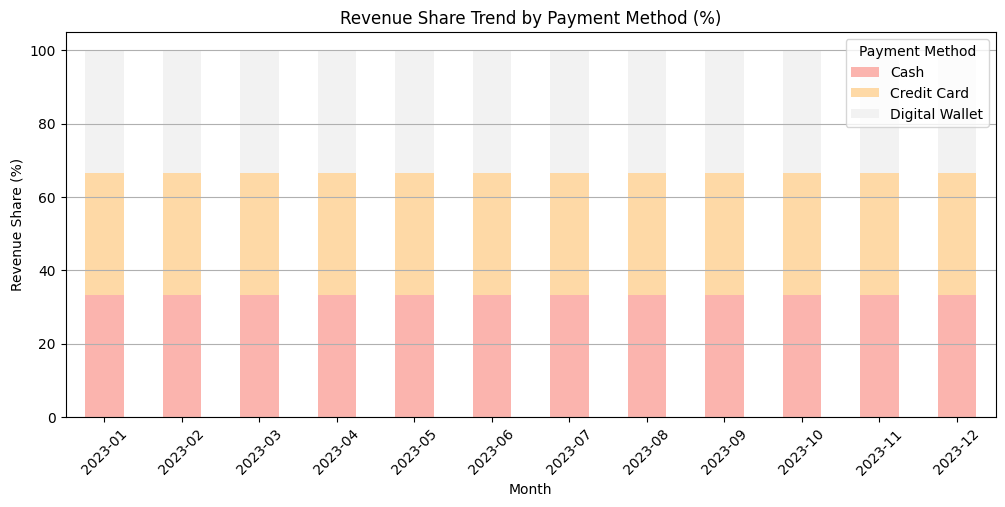

In [126]:
amount_pivot = monthly_payment.pivot(index="Month", columns="Payment Method", values="amount_share").fillna(0)
amount_pivot.plot(kind="bar", stacked=True, figsize=(12,5), colormap="Pastel1")
plt.title("Revenue Share Trend by Payment Method (%)")
plt.ylabel("Revenue Share (%)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Payment Method")
plt.grid(axis="y")
plt.show()


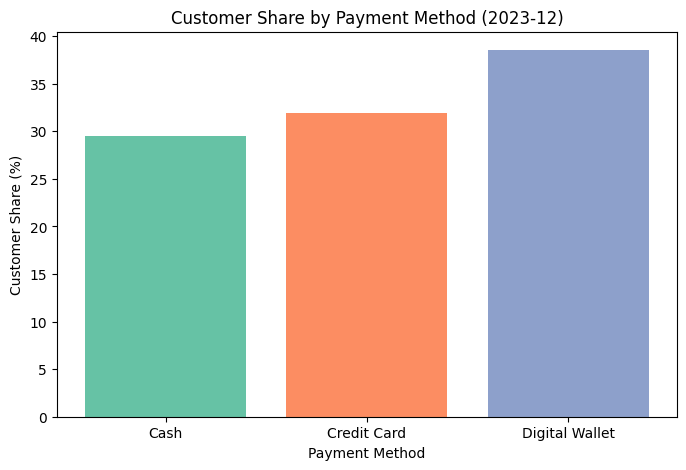

In [127]:
import matplotlib.pyplot as plt

# 选择某个月份
month_to_plot = monthly_payment["Month"].max()
subset = monthly_payment[monthly_payment["Month"] == month_to_plot]

plt.figure(figsize=(8,5))
plt.bar(subset["Payment Method"], subset["customer_share"], color=plt.cm.Set2.colors)
plt.title(f"Customer Share by Payment Method ({month_to_plot.strftime('%Y-%m')})")
plt.ylabel("Customer Share (%)")
plt.xlabel("Payment Method")
plt.show()


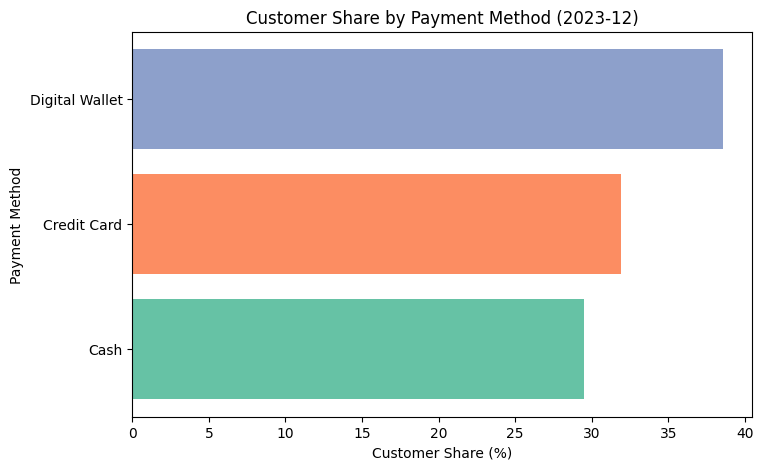

In [128]:
plt.figure(figsize=(8,5))
plt.barh(subset["Payment Method"], subset["customer_share"], color=plt.cm.Set2.colors)
plt.title(f"Customer Share by Payment Method ({month_to_plot.strftime('%Y-%m')})")
plt.xlabel("Customer Share (%)")
plt.ylabel("Payment Method")
plt.show()


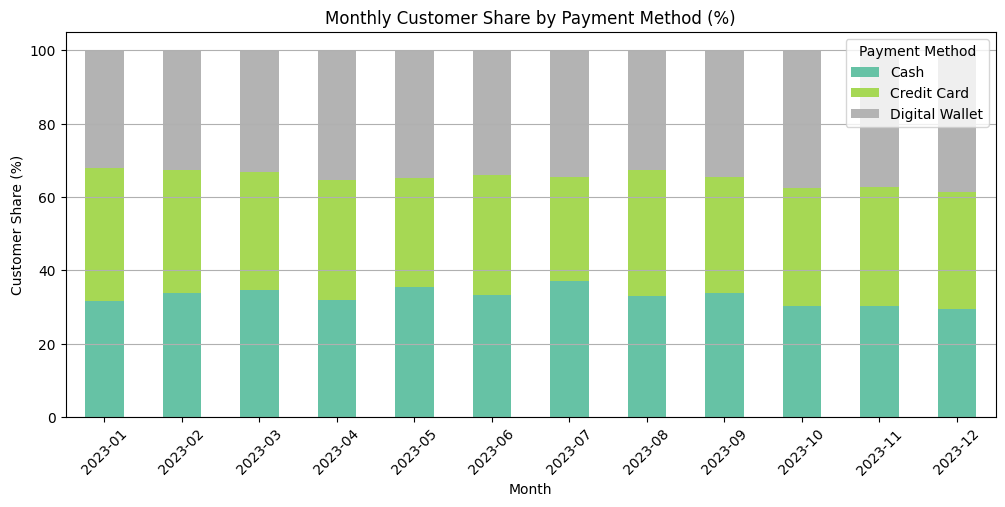

In [129]:
import pandas as pd

# 按月透视表
pivot = monthly_payment.pivot(index="Month", columns="Payment Method", values="customer_share").fillna(0)

# 百分比堆叠条形图
pivot.plot(kind="bar", stacked=True, figsize=(12,5), colormap="Set2")
plt.ylabel("Customer Share (%)")
plt.title("Monthly Customer Share by Payment Method (%)")
plt.xticks(rotation=45)
plt.legend(title="Payment Method")
plt.grid(axis="y")
plt.show()


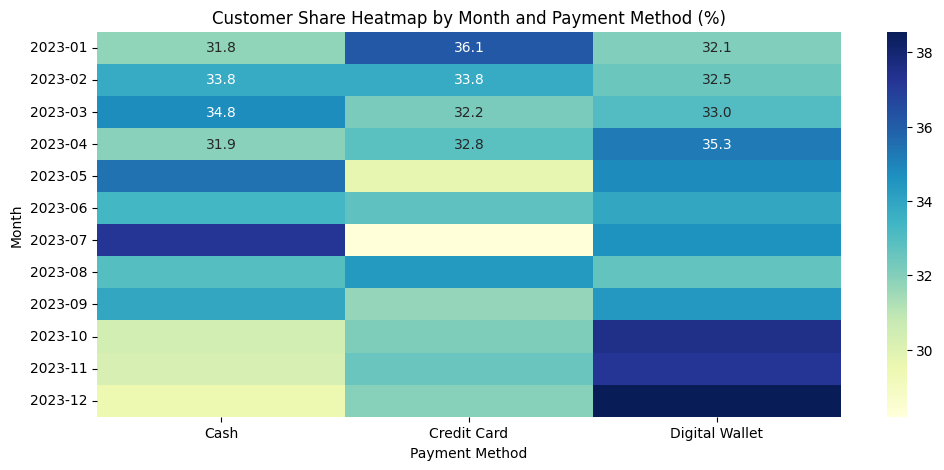

In [130]:
import seaborn as sns

# 透视表
heatmap_data = monthly_payment.pivot(index="Month", columns="Payment Method", values="customer_share").fillna(0)

plt.figure(figsize=(12,5))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Customer Share Heatmap by Month and Payment Method (%)")
plt.ylabel("Month")
plt.xlabel("Payment Method")
plt.show()


In [131]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 构造高消费标签
clean_df['high_spender'] = (clean_df['Total Spent'] > 10).astype(int)

# 类别特征编码
clean_df['Payment Method'] = LabelEncoder().fit_transform(clean_df['Payment Method'])
clean_df['Location'] = LabelEncoder().fit_transform(clean_df['Location'])

X = clean_df[['Quantity', 'Price Per Unit', 'Payment Method', 'Location']]
y = clean_df['high_spender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       560
           1       1.00      1.00      1.00       266

    accuracy                           1.00       826
   macro avg       1.00      1.00      1.00       826
weighted avg       1.00      1.00      1.00       826



d:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


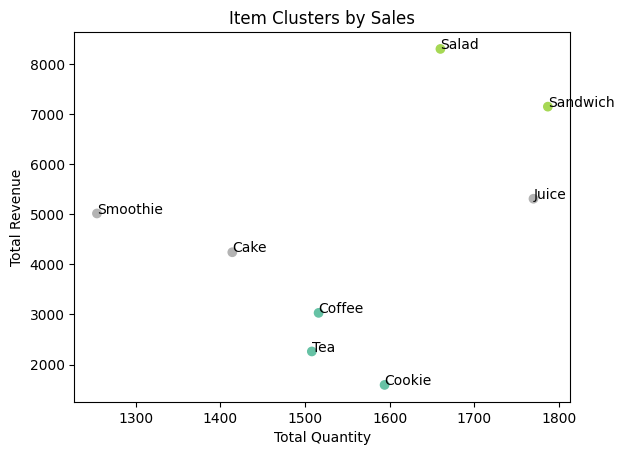

In [132]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 汇总每个商品的销量和总收入
item_summary = clean_df.groupby('Item').agg(
    total_quantity=('Quantity', 'sum'),
    total_revenue=('Total Spent', 'sum')
).reset_index()

# KMeans 聚类
kmeans = KMeans(n_clusters=3, random_state=42)
item_summary['cluster'] = kmeans.fit_predict(item_summary[['total_quantity','total_revenue']])

# 可视化
plt.scatter(item_summary['total_quantity'], item_summary['total_revenue'], c=item_summary['cluster'], cmap='Set2')
plt.xlabel('Total Quantity')
plt.ylabel('Total Revenue')
plt.title('Item Clusters by Sales')
for i, txt in enumerate(item_summary['Item']):
    plt.annotate(txt, (item_summary['total_quantity'][i], item_summary['total_revenue'][i]))
plt.show()


In [136]:
# 确保 Transaction Date 是 datetime 类型
clean_df['Transaction Date'] = pd.to_datetime(clean_df['Transaction Date'])

# 按月聚合 total_revenue
monthly_revenue = (
    clean_df
    .groupby(clean_df['Transaction Date'].dt.to_period('M'))  # 按月分组
    .agg(total_revenue=('Total Spent', 'sum'))               # 只聚合数值列
    .reset_index()
)

# 转回时间戳方便 Prophet 使用
monthly_revenue['ds'] = monthly_revenue['Transaction Date'].dt.to_timestamp()
monthly_revenue['y'] = monthly_revenue['total_revenue']

monthly_revenue[['ds','y']].head()



,ds,y
0,2023-01-01,3347.5
1,2023-02-01,2966.5
2,2023-03-01,2974.0
3,2023-04-01,3062.0
4,2023-05-01,2735.0


In [137]:
from prophet import Prophet

model = Prophet(yearly_seasonality=True)
model.fit(monthly_revenue[['ds','y']])

future = model.make_future_dataframe(periods=3, freq='M')
forecast = model.predict(future)

model.plot(forecast)


AttributeError: 'Prophet' object has no attribute 'stan_backend'

In [139]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
df_clean = clean_df.copy()
# 构造高消费标签
df_clean['high_spender'] = (df_clean['Total Spent'] > 10).astype(int)

# 编码类别特征
df_clean['Payment Method'] = LabelEncoder().fit_transform(df_clean['Payment Method'])
df_clean['Location'] = LabelEncoder().fit_transform(df_clean['Location'])

# 特征与标签
X = df_clean[['Quantity','Price Per Unit','Payment Method','Location']]
y = df_clean['high_spender']

# 拆分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 随机森林训练
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 模型评价
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       560
           1       1.00      1.00      1.00       266

    accuracy                           1.00       826
   macro avg       1.00      1.00      1.00       826
weighted avg       1.00      1.00      1.00       826



In [140]:
import pandas as pd
import numpy as np

# 假设 clean_df 已经是清洗好的数据
clean_df['Transaction Date'] = pd.to_datetime(clean_df['Transaction Date'])

# 构造高消费标签
clean_df['high_spender'] = (clean_df['Total Spent'] > 10).astype(int)


In [144]:
import pandas as pd
import numpy as np

# 假设 clean_df 已经清洗完毕
clean_df['Transaction Date'] = pd.to_datetime(clean_df['Transaction Date'])
clean_df['high_spender'] = (clean_df['Total Spent'] > 10).astype(int)

# 按月聚合特征
monthly_df = (
    clean_df.groupby(clean_df['Transaction Date'].dt.to_period('M'))
    .agg(
        total_revenue=('Total Spent','sum'),
        high_spender_count=('high_spender','sum'),
        avg_price=('Price Per Unit','mean'),
        avg_quantity=('Quantity','mean'),
        transaction_count=('Transaction ID','count')
    )
    .reset_index()
)

monthly_df['Month'] = monthly_df['Transaction Date'].dt.to_timestamp()



In [148]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 假设 clean_df 已经清洗完毕
clean_df['Transaction Date'] = pd.to_datetime(clean_df['Transaction Date'])
clean_df['Month'] = clean_df['Transaction Date'].dt.to_period('M')

monthly = clean_df.groupby('Month').agg(
    total_revenue=('Total Spent','sum'),
    avg_price=('Price Per Unit','mean'),
    avg_quantity=('Quantity','mean'),
    transaction_count=('Transaction ID','count')
).reset_index()

# 将 period 转换为整数或时间戳特征
monthly['month_num'] = (monthly['Month'].dt.year - monthly['Month'].dt.year.min())*12 + monthly['Month'].dt.month
# 自变量 X：月度特征
X = monthly[['avg_price','avg_quantity','transaction_count','month_num']]
y = monthly['total_revenue']

# 训练测试集拆分（顺序拆分，不打乱时间顺序）
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# 训练线性回归
model = LinearRegression()
model.fit(X_train, y_train)

# 模型预测 & 评价
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))
# 预测月份特征
target_month_num = (2024 - monthly['Month'].dt.year.min())*12 + 5  # 2024年5月
# 特征假设：平均值参考最近月份
avg_price = monthly['avg_price'].iloc[-1]
avg_quantity = monthly['avg_quantity'].iloc[-1]
transaction_count = monthly['transaction_count'].iloc[-1]

X_future = pd.DataFrame({
    'avg_price':[avg_price],
    'avg_quantity':[avg_quantity],
    'transaction_count':[transaction_count],
    'month_num':[target_month_num]
})

pred_2024_05 = model.predict(X_future)[0]
print("线性回归预测 2024-05 营业额:", pred_2024_05)



MAE: 76.80456977181409
RMSE: 87.99628575461253
R2: 0.6906071673912009
线性回归预测 2024-05 营业额: 2865.197026070926


In [149]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# 1️⃣ 编码类别特征
df_model = clean_df.copy()
df_model['Payment Method'] = LabelEncoder().fit_transform(df_model['Payment Method'])
df_model['Location'] = LabelEncoder().fit_transform(df_model['Location'])

# 2️⃣ 特征和标签
X = df_model[['Quantity','Price Per Unit','Payment Method','Location']]
y = df_model['high_spender']

# 3️⃣ 拆分训练集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4️⃣ 训练模型
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 5️⃣ 构造 2024-05 月候选交易
# 简单假设平均每天交易数、数量和单价分布参考 2023-05
may_candidates = df_model[df_model['Transaction Date'].dt.month==5].copy()  # 用去年5月模拟
may_candidates['Transaction Date'] = pd.Timestamp('2024-05-01')  # 设置为目标月份

# 保留特征
X_may = may_candidates[['Quantity','Price Per Unit','Payment Method','Location']]

# 6️⃣ 预测高消费交易
may_candidates['high_spender_pred'] = clf.predict(X_may)
high_spender_count = may_candidates['high_spender_pred'].sum()
print("预测 2024-05 高消费交易笔数:", high_spender_count)


预测 2024-05 高消费交易笔数: 107


In [150]:
import pandas as pd
import numpy as np

# 假设 clean_df 已清洗完毕
clean_df['Transaction Date'] = pd.to_datetime(clean_df['Transaction Date'])
monthly_revenue = clean_df.groupby(clean_df['Transaction Date'].dt.to_period('M')) \
                          .agg(total_revenue=('Total Spent','sum')) \
                          .reset_index()
monthly_revenue['ds'] = monthly_revenue['Transaction Date'].dt.to_timestamp()
monthly_revenue['y'] = monthly_revenue['total_revenue']

# 只保留目标序列
series = monthly_revenue['y'].values.astype(float)


In [151]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1,1))

# 构建输入序列
def create_sequences(data, seq_length=3):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 3  # 用过去3个月预测下一个月
X, y = create_sequences(series_scaled, seq_length)

print("X shape:", X.shape)  # (样本数, 3, 1)
print("y shape:", y.shape)  # (样本数, 1)


X shape: (9, 3, 1)
y shape: (9, 1)


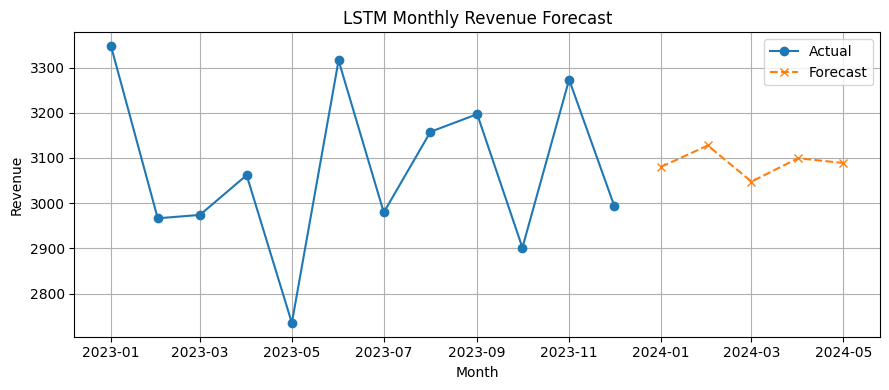

,Transaction Date,Predicted Revenue
7,2023-08-01,3158.000000
8,2023-09-01,3197.000000
9,2023-10-01,2901.500000
10,2023-11-01,3273.500000
11,2023-12-01,2993.500000
12,2024-01-01,3080.306885
13,2024-02-01,3127.657715
14,2024-03-01,3047.719238
15,2024-04-01,3099.460205
16,2024-05-01,3088.877441


In [169]:
from lstm_predicte import predict_next_months_df

# 假设 clean_df 是你的销售数据
pred_df = predict_next_months_df(clean_df, months_ahead=5)
pred_df.tail(10)


              0    1    2
2024-01-01  107  109  133
2024-02-01  107  108  132
2024-03-01  107  108  133
2024-04-01  108  108  135
2024-05-01  108  108  135


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20116 (\N{CJK UNIFIED IDEOGRAPH-4E94}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26376 (\

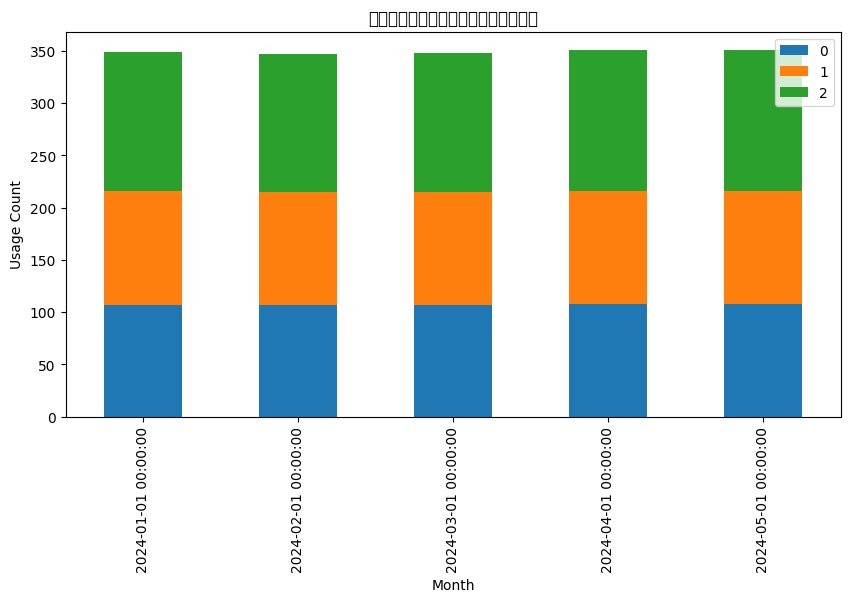

In [172]:
import importlib
import lstm_predicte

importlib.reload(lstm_predicte)
from lstm_predicte import predict_payment_usage_lstm

# 假设 clean_df 是你的销售数据
pred_payment_df = predict_payment_usage_lstm(clean_df, n_months=5,seq_length=3)
print(pred_payment_df)
pred_payment_df.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title("未来五个月每种支付方式使用次数预测")
plt.xlabel("Month")
plt.ylabel("Usage Count")
plt.show()


In [157]:
import pandas as pd
import numpy as np

def generate_data_summary(df):
    """
    生成数据摘要报告，包括均值、中位数、众数、最大值、最小值、四分位数和IQR。
    适用数值型列和非数值型列。
    """
    report = []
    
    for col in df.columns:
        col_data = df[col]
        dtype = col_data.dtype
        
        # 如果是 Period 类型，先转换为字符串
        if isinstance(col_data.dtype, pd.PeriodDtype):
            col_data = col_data.astype(str)
            dtype = col_data.dtype
        
        # 初始化字典
        summary = {'Column': col, 'Type': str(dtype)}
        
        # 判断是否为数值类型
        if np.issubdtype(col_data.dtype, np.number):
            summary['Mean'] = col_data.mean()
            summary['Median'] = col_data.median()
            modes = col_data.mode()
            summary['Mode'] = modes[0] if not modes.empty else np.nan
            summary['Max'] = col_data.max()
            summary['Min'] = col_data.min()
            q1 = col_data.quantile(0.25)
            q3 = col_data.quantile(0.75)
            summary['Q1'] = q1
            summary['Q3'] = q3
            summary['IQR'] = q3 - q1
        else:
            # 非数值列
            modes = col_data.mode()
            summary['Mode'] = modes[0] if not modes.empty else np.nan
            summary['Unique Values'] = col_data.nunique()
            summary['Top 5 Values'] = list(col_data.value_counts().head(5).index)
        
        report.append(summary)
    
    report_df = pd.DataFrame(report)
    return report_df

# ------------------------------
# 使用示例
# ------------------------------
summary_report = generate_data_summary(clean_df)
pd.set_option('display.max_columns', None)
print(summary_report)


             Column            Type                 Mode  Unique Values  \
0    Transaction ID          object          TXN_1000555         4128.0   
1              Item          object                Juice            8.0   
2          Quantity         float64                  5.0            NaN   
3    Price Per Unit         float64                  3.0            NaN   
4       Total Spent         float64                  6.0            NaN   
5    Payment Method           int32                    2            NaN   
6          Location           int32                    0            NaN   
7  Transaction Date  datetime64[ns]  2023-03-13 00:00:00          446.0   
8             Month          object              2023-09           12.0   
9      high_spender           int32                    0            NaN   

                                        Top 5 Values      Mean  Median   Max  \
0  [TXN_1961373, TXN_9362958, TXN_1234390, TXN_62...       NaN     NaN   NaN   
1           [J